# Games Dataset Classification (Optimized + Charts + Save Weights)

**Pipeline:**
1.  **Data Loading & Preprocessing**: Cleaning text, removing noise.
2.  **Visualizations**: Word frequency, vocab coverage, genre distribution.
3.  **Model Training**: Bi-directional LSTM/RNN/GRU with gradient clipping and class weights.
4.  **Saving**: Saving model weights to Google Drive.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# --- PATH CONFIGURATION ---
DESCRIPTION_CSV_PATH = ".steam_description_data.csv"
DATA_CSV_PATH = ".steam.csv"

In [ ]:
# Load Data
try:
    description_df = pd.read_csv(DESCRIPTION_CSV_PATH)
    data_df = pd.read_csv(DATA_CSV_PATH)

    desc_df_subset = description_df[['steam_appid', 'detailed_description']]
    data_df_subset = data_df[['appid', 'genres']]
    merged_df = pd.merge(desc_df_subset, data_df_subset, left_on='steam_appid', right_on='appid', how='inner')
    df = merged_df.dropna(subset=['detailed_description', 'genres'])
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Files not found. Please check the CSV paths.")

Data loaded successfully. Shape: (27075, 4)


In [ ]:
# --- Preprocessing ---
stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor'}
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s\']', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("Preprocessing text...")
preprocessed_texts = [preprocess_text(p) for p in df['detailed_description'].to_list()]
preprocessed_texts = [re.sub(r'\bgame\b', '', p) for p in preprocessed_texts]
print("Preprocessing complete.")

Preprocessing text...
Preprocessing complete.


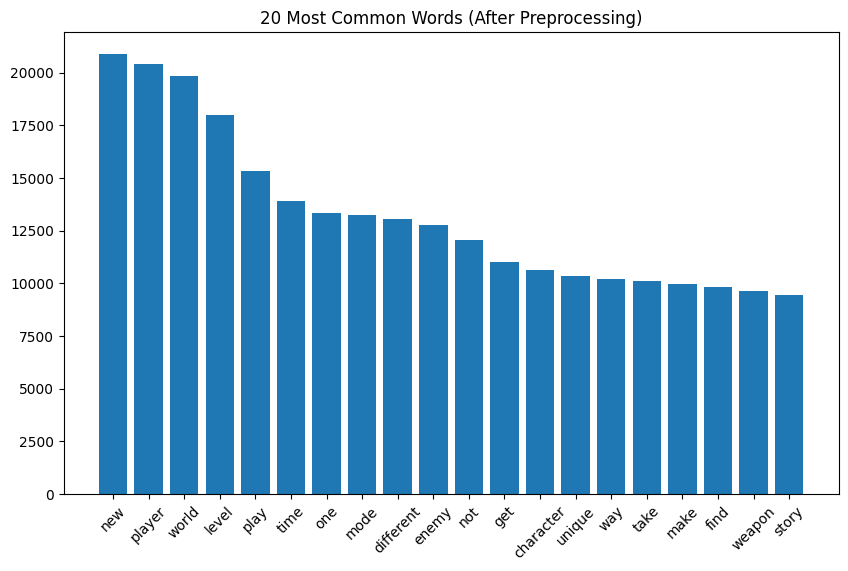

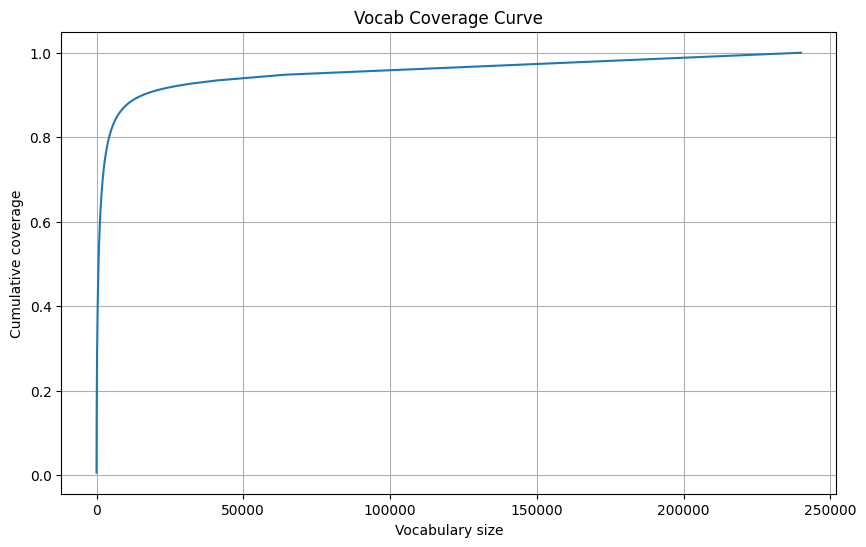

In [ ]:
# --- Visualizations ---
def plot_most_common_words(input_text):
    tokens = " ".join(input_text).lower().split()
    word_counts = Counter(tokens)
    common_words = word_counts.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title("20 Most Common Words (After Preprocessing)")
    plt.show()

def plot_vocab_coverage(input_text):
    tokens = " ".join(input_text).lower().split()
    word_counts = Counter(tokens)
    counts = np.array(sorted(word_counts.values(), reverse=True))
    total = counts.sum()
    cumulative_coverage = np.cumsum(counts) / total

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_coverage)
    plt.xlabel("Vocabulary size")
    plt.ylabel("Cumulative coverage")
    plt.title("Vocab Coverage Curve")
    plt.grid(True)
    plt.show()

plot_most_common_words(preprocessed_texts)
plot_vocab_coverage(preprocessed_texts)

In [ ]:
# Genre Labeling
genre_list_raw = []
for genre_str in df["genres"]:
    temp = genre_str.split(';')
    temp = [x.lower() for x in temp]
    genre_list_raw.append(temp)

EXCLUDE_GENRES = ["early access", "free to play"]
all_genres = [g for sublist in genre_list_raw for g in sublist]
genre_counts = Counter(all_genres)
top_genres = [g for g, _ in genre_counts.most_common() if g not in EXCLUDE_GENRES][:10]

genre_list_processed = [[g for g in sublist if g in top_genres] for sublist in genre_list_raw]
for i in range(len(genre_list_processed)):
    if len(genre_list_processed[i]) == 0:
        genre_list_processed[i] = ["other"]

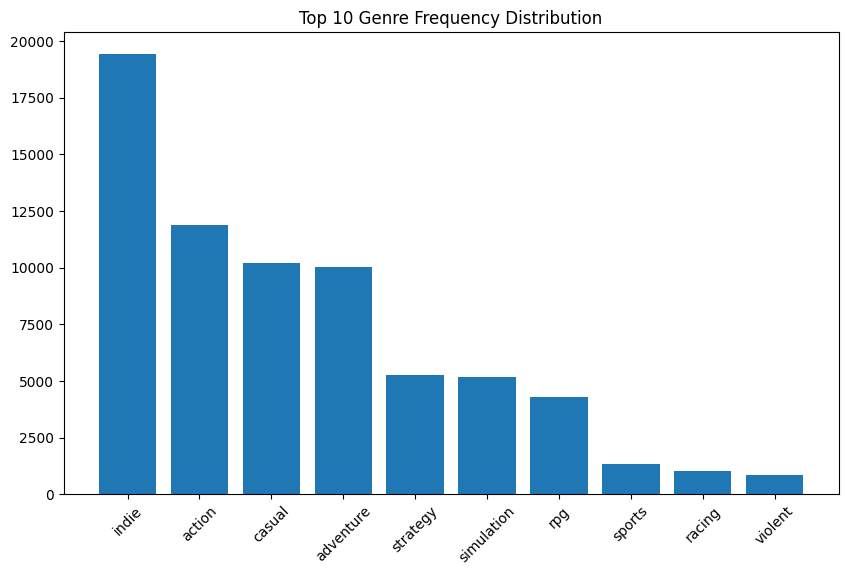

In [ ]:
def plot_genre_freq_distribution(genre_counts):
    filtered_counts = Counter({g: c for g, c in genre_counts.items() if g not in EXCLUDE_GENRES})
    common_words = filtered_counts.most_common(10)
    genre, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    plt.bar(genre, counts)
    plt.xticks(rotation=45)
    plt.title("Top 10 Genre Frequency Distribution")
    plt.show()

plot_genre_freq_distribution(genre_counts)

In [ ]:
# Prepare Data
mlb = MultiLabelBinarizer()
final_labels = mlb.fit_transform(genre_list_processed)
final_texts = preprocessed_texts
classes = mlb.classes_
print("Classes:", classes)

Classes: ['action' 'adventure' 'casual' 'indie' 'other' 'racing' 'rpg' 'simulation'
 'sports' 'strategy' 'violent']


In [ ]:
# --- Hyperparameters ---
VOCAB_SIZE_LIMIT = 30000
MAX_SEQ_LEN = 300
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(classes) #--11 different classes
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 15
PATIENCE = 6
BATCH_SIZE = 64
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2
RANDOM_SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
# Vocabulary & Tokenization
words = [w for t in final_texts for w in t.split()]
freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE_LIMIT)]
stoi = {w:i for i,w in enumerate(vocab)}
VOCAB_SIZE_MODEL = len(vocab)

def encode_text(t):
    tokens = t.split()
    if len(tokens) > MAX_SEQ_LEN:
        tokens = tokens[:MAX_SEQ_LEN]
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

class GameDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode_text(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

In [ ]:
# Split Data
X_train_val, X_test, y_train_val, y_test = train_test_split(final_texts, final_labels, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = GameDataset(X_train, y_train)
val_ds = GameDataset(X_val, y_val)
test_ds = GameDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 18410, Val size: 4603, Test size: 4062


In [ ]:
# --- Model Definitions ---
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, hn = self.rnn(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hn, cn) = self.lstm(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, hn = self.gru(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

In [ ]:
# Class Weights
pos_counts = np.sum(final_labels, axis=0)
total_samples = len(final_labels)
neg_counts = total_samples - pos_counts
raw_weights = neg_counts / (pos_counts + 1e-5)
softened_weights = np.sqrt(raw_weights)
class_weights_tensor = torch.tensor(softened_weights, dtype=torch.float32).to(device)
print("Softened Pos Class Weights:", class_weights_tensor)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            probs = torch.sigmoid(predictions)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return epoch_loss / len(loader), acc, f1_micro, f1_macro, prec, rec

def run_training(model_class, model_name):
    print(f"\n================ Training {model_name} (Bidirectional) ================")
    model = model_class(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_dl, optimizer, criterion)
        val_loss, acc, f1_mic, f1_mac, prec, rec = evaluate(model, val_dl, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1 Mic: {f1_mic:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{model_name}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

    print(f"Loading best {model_name} model for testing...")
    model.load_state_dict(torch.load(f'{model_name}_best.pt'))
    test_loss, t_acc, t_f1_mic, t_f1_mac, t_prec, t_rec = evaluate(model, test_dl, criterion)

    print(f"\n--- {model_name} FINAL TEST RESULTS ---")
    print(f"Loss:              {test_loss:.4f}")
    print(f"Accuracy:          {t_acc:.4f}")
    print(f"F1 Score (Micro):  {t_f1_mic:.4f}")
    print(f"F1 Score (Macro):  {t_f1_mac:.4f}")
    print(f"Precision (Macro): {t_prec:.4f}")
    print(f"Recall (Macro):    {t_rec:.4f}")

    # Return the trained model so we can save it later
    return model

Softened Pos Class Weights: tensor([ 1.1290,  1.3034,  1.2852,  0.6278, 10.4006,  5.0439,  2.2979,  2.0525,
         4.4137,  2.0396,  5.5783], device='cuda:0')


In [ ]:
# Run Training and Capture Models
trained_lstm = run_training(LSTMModel, "LSTM")
trained_rnn = run_training(RNNModel, "RNN")
trained_gru = run_training(GRUModel, "GRU")


================ Training LSTM (Bidirectional) ================
Epoch 1/15 | Train Loss: 0.6172 | Val Loss: 0.5779 | F1 Mic: 0.5732
Epoch 2/15 | Train Loss: 0.5596 | Val Loss: 0.5207 | F1 Mic: 0.5845
Epoch 3/15 | Train Loss: 0.4727 | Val Loss: 0.4688 | F1 Mic: 0.6677
Epoch 4/15 | Train Loss: 0.4194 | Val Loss: 0.4562 | F1 Mic: 0.6729
Epoch 5/15 | Train Loss: 0.3780 | Val Loss: 0.4640 | F1 Mic: 0.6537
Epoch 6/15 | Train Loss: 0.3360 | Val Loss: 0.4683 | F1 Mic: 0.6753
Epoch 7/15 | Train Loss: 0.2928 | Val Loss: 0.4987 | F1 Mic: 0.6903
Epoch 8/15 | Train Loss: 0.2514 | Val Loss: 0.5330 | F1 Mic: 0.6885
Epoch 9/15 | Train Loss: 0.2138 | Val Loss: 0.5728 | F1 Mic: 0.6892
Epoch 10/15 | Train Loss: 0.1783 | Val Loss: 0.6391 | F1 Mic: 0.6855
Early stopping triggered.
Loading best LSTM model for testing...

--- LSTM FINAL TEST RESULTS ---
Loss:              0.4560
Accuracy:          0.1654
F1 Score (Micro):  0.6714
F1 Score (Macro):  0.5496
Precision (Macro): 0.5348
Recall (Macro):    0.5746


In [ ]:
# --- Mount Google Drive and Save Weights ---
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Create Directory
save_path = '/content/drive/MyDrive/ColabNotebooks/games6405/'
os.makedirs(save_path, exist_ok=True)
print(f"Weights will be saved to: {save_path}")

# Save Weights
rnn_save_file = os.path.join(save_path, 'rnn_mod1_model_weights.pth')
torch.save(trained_rnn.state_dict(), rnn_save_file)
print(f"Saved trained RNN model weights to: {rnn_save_file}")

lstm_save_file = os.path.join(save_path, 'lstm_mod1_model_weights.pth')
torch.save(trained_lstm.state_dict(), lstm_save_file)
print(f"Saved trained LSTM model weights to: {lstm_save_file}")

gru_save_file = os.path.join(save_path, 'gru_mod1_model_weights.pth')
torch.save(trained_gru.state_dict(), gru_save_file)
print(f"Saved trained GRU model weights to: {gru_save_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Weights will be saved to: /content/drive/MyDrive/ColabNotebooks/games6405
Saved trained RNN model weights to: /content/drive/MyDrive/ColabNotebooks/games6405/rnn_mod1_model_weights.pth
Saved trained LSTM model weights to: /content/drive/MyDrive/ColabNotebooks/games6405/lstm_mod1_model_weights.pth
Saved trained GRU model weights to: /content/drive/MyDrive/ColabNotebooks/games6405/gru_mod1_model_weights.pth


In [ ]:
# === Export artifacts (run after training) ===
import os, json, re
from typing import Dict
import torch
import torch.nn as nn

# Compute project root (this notebook is under <root>/Games/)
ROOT = os.path.dirname(os.getcwd())
DOMAIN = "games"
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

# 1) labels.txt
labels = None
if 'mlb' in globals() and hasattr(mlb, 'classes_'):
    labels = list(mlb.classes_)
elif 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
elif 'classes' in globals():
    labels = list(classes)
if not labels or len(labels) < 2:
    raise RuntimeError("Could not determine labels. Ensure 'mlb'/'le'.classes_ or a 'classes' list exists.")
labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for lab in labels:
        f.write(f"{lab}\n")
print(f"Wrote {labels_path} ({len(labels)} labels)")

# 2) preprocessor.json
word_index: Dict[str, int] = {}
if 'stoi' in globals() and isinstance(stoi, dict):
    word_index = {str(k): int(v) for k, v in stoi.items()}
elif 'word_index' in globals() and isinstance(word_index, dict):
    word_index = word_index
elif 'vocab' in globals() and isinstance(vocab, list):
    word_index = {str(w): int(i) for i, w in enumerate(vocab)}
else:
    raise RuntimeError("Could not determine word_index ('stoi', 'word_index', or 'vocab' required).")

max_length = 256
for key in ("MAX_SEQ_LEN", "MAX_LEN", "SEQ_LEN", "MAX_LENGTH"):
    if key in globals():
        try:
            max_length = int(globals()[key])
            break
        except Exception:
            pass
lowercase = True if 'LOWERCASE' not in globals() else bool(LOWERCASE)

padding_idx = 0
if '<PAD>' in word_index:
    padding_idx = int(word_index['<PAD>'])

oov_token_id = 1
if '<UNK>' in word_index:
    oov_token_id = int(word_index['<UNK>'])

preproc = {
    "word_index": word_index,
    "max_length": int(max_length),
    "lowercase": bool(lowercase),
    "oov_token_id": int(oov_token_id),
    "padding_idx": int(padding_idx),
    "tokenizer": "regex_basic",
}
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")
with open(preproc_path, "w", encoding="utf-8") as f:
    json.dump(preproc, f, ensure_ascii=False)
print(f"Wrote {preproc_path} (|word_index|={len(word_index)})")

# 3) model.ts (TorchScript)
_candidates = [
    'best_model',
    'trained_lstm', 'trained_gru', 'trained_rnn',
    'lstm_model', 'gru_model', 'rnn_model',
]
model_to_export = None
model_name = None
for name in _candidates:
    if name in globals() and isinstance(globals()[name], nn.Module):
        model_to_export = globals()[name]
        model_name = name
        break
if model_to_export is None:
    raise RuntimeError("No trained model found to export. Expected one of: " + ", ".join(_candidates))

model_to_export.eval()
try:
    scripted = torch.jit.script(model_to_export)
    export_mode = "scripted"
except Exception:
    dummy = torch.ones((1, int(max_length)), dtype=torch.long)
    scripted = torch.jit.trace(model_to_export, dummy, strict=False)
    export_mode = "traced"

ts_canonical = os.path.join(BUNDLE_DIR, "model.ts")
scripted.save(ts_canonical)
print(f"Saved {export_mode} TorchScript to {ts_canonical}")

if model_name:
    ts_named = os.path.join(BUNDLE_DIR, f"{model_name}.ts")
    scripted.save(ts_named)
    print(f"Saved named TorchScript to {ts_named}")

